# Bildsegmentierung

Bei der Bildsegmentierung soll das Bild in sinnvolle Bildteile (Segmente) unterteilt werden. Diese Segmente bilden anschließend die Grundlage für die weitere Verarbeitung.

In [95]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import pandas
import os
import cv2 # opencv-python installieren
from scipy.ndimage import center_of_mass
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
import plotly.express as px
import ipywidgets as wg
from IPython.display import display

### Hounsfield-Einheiten

Im folgenden Beispiel soll es darum gehen, die Lunge aus einer CT-Aufnahme zu segmentieren.
Um das weitere Vorgehen zu verstehen, ist es hilfreich zu wissen, was es mit Hounsfield-Einheiten und der Hounsfield-Skala auf sich hat.
Die Hounsfield-Skala gibt Auskunft über die Abschwächung der Röntgenstrahlung bei einer Computertomographie. Als Referenzwerte nutzt man die Relation zu Luft und Wasser.

DIe sogenannte CT-Zahl wird anhand des linearen Schwächungskoeffizienten des betrachteten Gewebes im Verhältnis zu Wasser und Luft berechnet.
<br/>
<div>
<img src="CT-Zahl_Formel.png" width="700"/>
</div>

Hier noch eine Hounsfield-Skala für verschiedene Gewebearten:

<div>
<img src="Hounsfield-Skala.png" width="900"/>
</div>

### Laden der Daten und Definition der Hilfsfunktionen

In [96]:
def load_scan(path):
    slices = [pydicom.read_file(path+"/"+s) for s in os.listdir(path) ]
    slices.sort(key = lambda x: int(x.AcquisitionNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness
        s.SamplesPerPixel = 1

    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans[:100]])
    # Konvertierung zu int16
    image = image.astype(np.int16)
    # Pixel außerhalb des Scans auf Wert 1 setzen
    # Intercept normalerweise -1024, also liegt Luft ca. bei 0
        # (Interceptor: Wert im Verhältnis zwischen gespeicherten Werten in Pixeldaten und der Ausgabeeinheit, spezifiziert im Rescale Typ)
    image[image == -2000] = 0
    # Konvertierung der Pixelwerte zu Hounsfield-Einheiten (Hounsfield units - HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope

    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)

    image += np.int16(intercept)

    return np.array(image, dtype=np.int16)

path =  "dicom_dir"
patient = load_scan(path)
imgs = get_pixels_hu(patient)

### Anzeigen einiger Beispielbilder

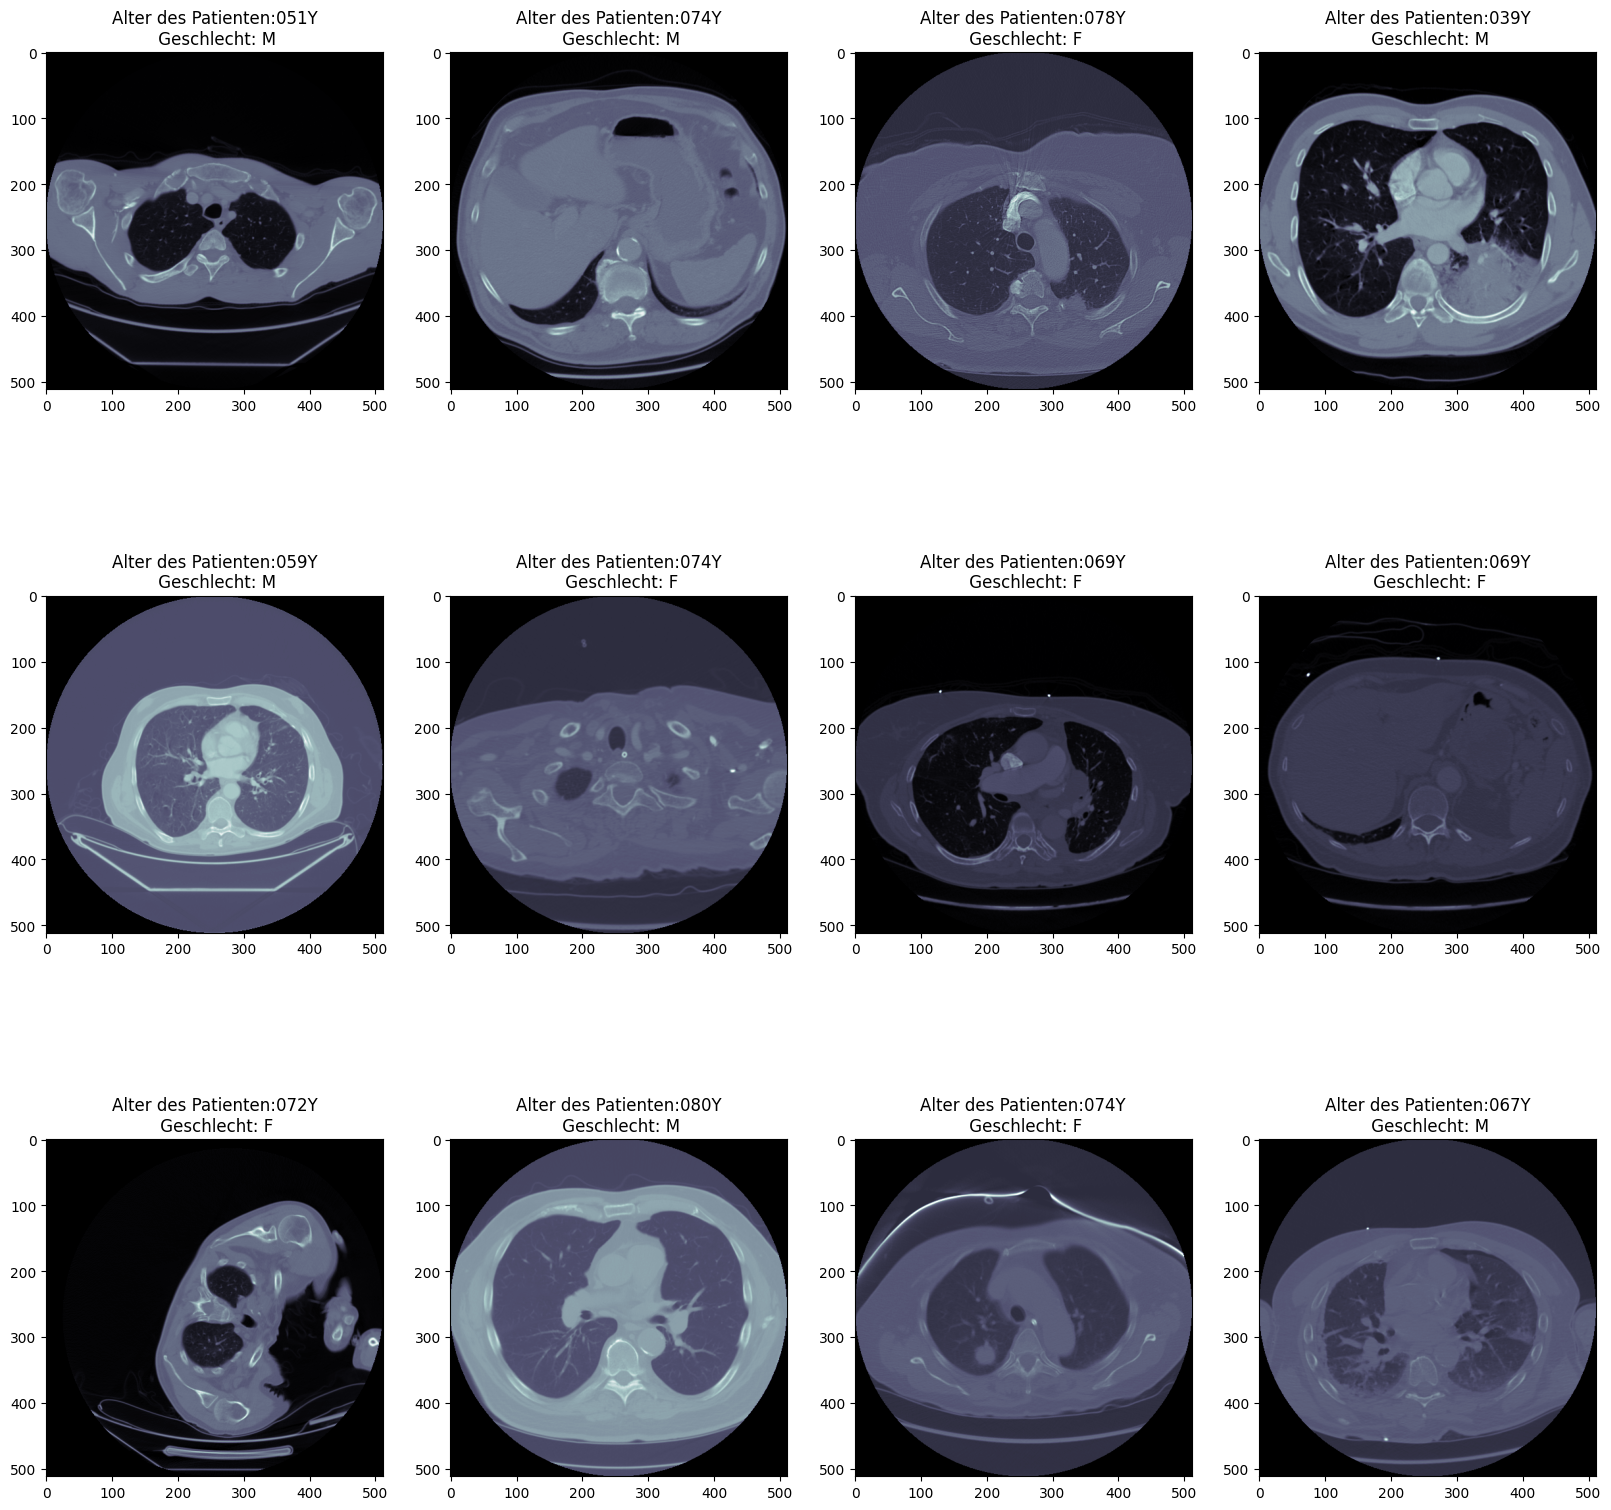

In [97]:
fig = plt.figure(figsize=(20,20))
for num,image in enumerate(imgs[:12]):
    ax = fig.add_subplot(3,4,num+1)
    ax.imshow(image, cmap=plt.cm.bone)
    ax.set_title(f"Alter des Patienten:{patient[num].PatientAge}\n Geschlecht: {patient[num].PatientSex}")
plt.show()

In [98]:
print('Dicom ID (0-99):')
simg = wg.BoundedIntText(value=4, min=0, max=99, step=1, disabled=False) #
display(simg)

Dicom ID (0-99):


BoundedIntText(value=4, max=99)

In [99]:
# Anzeigen eines Histogramms der HU
img = np.copy(imgs[simg.value])
fig = px.histogram(x=img.flatten())
fig.show()

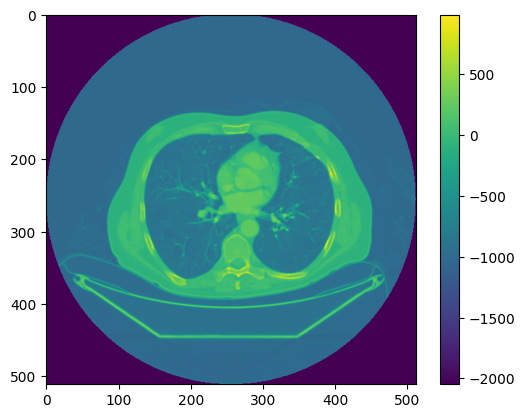

In [100]:
# Anzeigen des Bildes mit HU als Pixelwerte
plt.imshow(imgs[simg.value])
plt.colorbar()

In [101]:
print('Schwellenwert:')
lt = wg.IntSlider(value=-550, min=imgs.min(), max=imgs.max(), step=1, disabled=False)
display(lt)

Schwellenwert:


IntSlider(value=-550, max=3071, min=-2048)

CT-Zahl der Lunge liegt zwischen -550 und -950

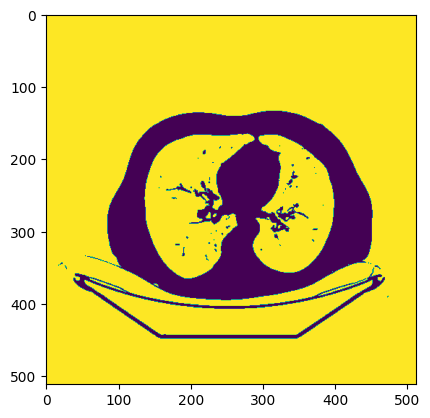

In [102]:
# Nur Pixel unter dem Schwellenwert anzeigen (Ausgabe als Boolesche Werte)
mask = imgs[simg.value] < lt.value
plt.imshow(mask)

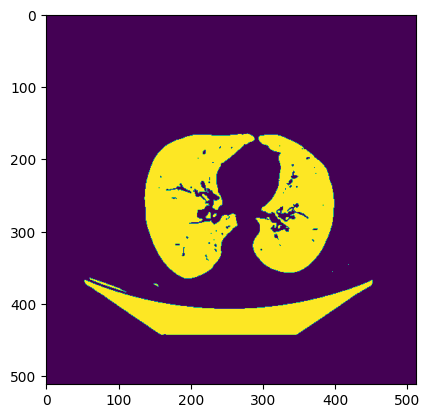

In [103]:
# Entfernen der Bereiche am Bildrand
mask = clear_border(mask)
plt.imshow(mask)

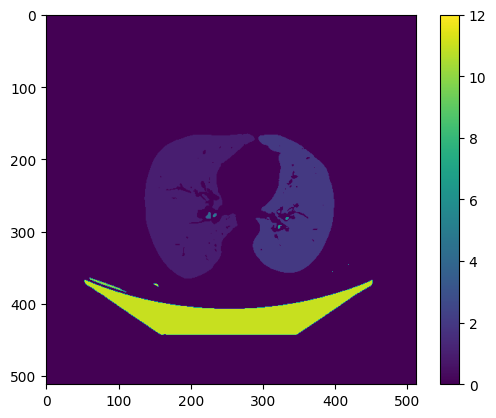

In [104]:
# Einzelne zusammenhängende Bereiche jeweils mit einem Label versehen (zur Unterscheidung voneinander)
mask_labeled = label(mask)
plt.imshow(mask_labeled)
plt.colorbar()

Der erste Schritt, um nur noch die Lungenflügel anzuzeigen, ist, die kleinen Bereiche zu entfernen.
Aus diesem Grund berechnen wir die Größe der einzelnen Bereiche, sortieren sie der Größe nach und verwerfen alles bis auf die 3 Größten Bereiche.
Dass wir 3 Bereiche wählen, obwohl wir nur 2 Lungenflügel darstellen wollen, liegt daran, dass auf manchen Bildern der Tisch größer sein könnte als einer der beiden Flügel.
So gehen wir also sicher, dass die interessanten Bereiche auf dem Bild verbleiben.

In [105]:
slc = mask_labeled
rps = regionprops(slc)
areas = [r.area for r in rps]
print(len(areas))   # Anzhal der einzelnen Bereiche
areas               # Zeigt die Größe der einzelnen Bereiche

12


[17795.0,
 13429.0,
 10.0,
 44.0,
 19.0,
 14.0,
 15.0,
 1.0,
 1.0,
 133.0,
 12072.0,
 14.0]

In [106]:
# Sortiert die Bereiche ihrer Größe entsprechend (groß -> klein)
idxs = np.argsort(areas)[::-1] # -1 kehrt die Reihenfolge um
idxs

array([ 0,  1, 10,  9,  3,  4,  6, 11,  5,  2,  8,  7], dtype=int64)

In [107]:
# Entfernen aller Bereiche bis auf die 3 größten
new_slc = np.zeros_like(slc)
for i in idxs[:3]:
    new_slc[tuple(rps[i].coords.T)] = i+1

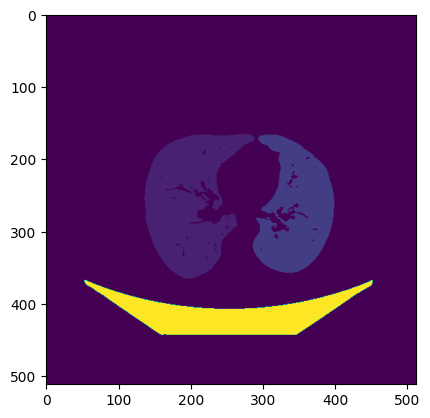

In [108]:
plt.imshow(new_slc)

Um auch noch den Tisch zu entfernen, berechnen wir zunächst die Massenmittelpunkte der einzelnen Bereiche und betrachten deren y-Koordinate.

In [109]:
labels = label(new_slc, background=0)
center_of_mass(labels==3) # Gibt die y- und x-Koordinaten des Massenschwerpunkts von Bereich 3 an

(416.07181908548705, 252.38527170311465)

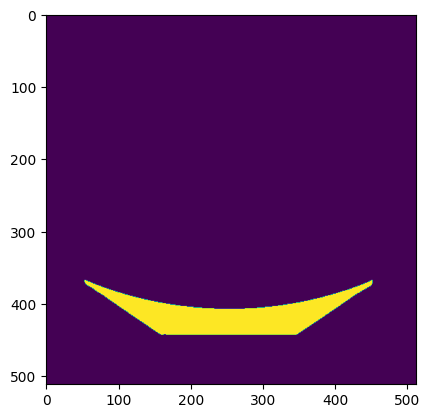

In [110]:
plt.imshow(labels==3) # Anzeigen des Bereichs mit dem Label 3

In [111]:
# Definition der Funktion, um den Tisch zu entfernen
def delete_table(slc_ot):
    labels = label(slc_ot, background=0)
    idxs = np.unique(labels)[1:] # Einzelne Bereiche ohne Hintergrund (0 = Hintergund => Anfang bei 1)
    COM_ys = np.array([center_of_mass(labels==i)[0] for i in idxs]) # Berechnen der y-Koordinaten der Massenschwerpunkte
    for idx, COM_y in zip(idxs, COM_ys):
        if (COM_y < 0.3*slc_ot.shape[0]):   # Bereiche mit Massenschwerpunkten in den unteren 30% des Bildes entfernen
            slc_ot[labels==idx] = 0
        elif (COM_y > 0.6*slc_ot.shape[0]): # Bereiche mit  Massenschwerpunkten in den oberen 30% des Bildes entfernen
            slc_ot[labels==idx] = 0
    return slc_ot

In [112]:
mask_ot = delete_table(new_slc) # Funktion ausführen

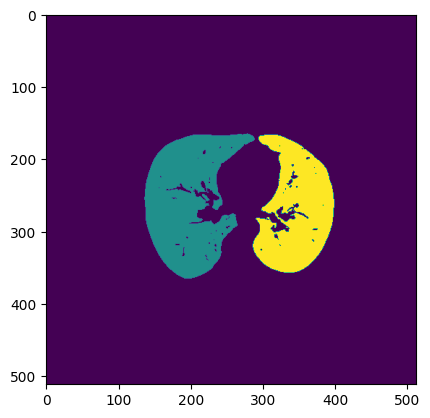

In [113]:
plt.imshow(mask_ot)

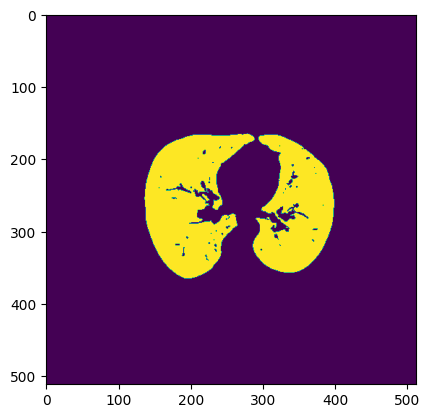

In [114]:
# Gibt allen Bereichen den gleichen Wert (gleiche Farbe)
labels = label(mask_ot, background=0)
new_slc[labels==1] = 1
new_slc[labels==2] = 1
plt.imshow(new_slc)

In [115]:
# Zuschneiden des Bildbereichs auf Bereiche, die nicht 0 sind
def crop_image(mask_ot, display=False):

    coords = np.array(np.nonzero(mask_ot))
    top_left = np.min(coords)
    bottom_right = np.max(coords)

    cropped_image = mask_ot[top_left:bottom_right,
                    top_left:bottom_right]
    return cropped_image

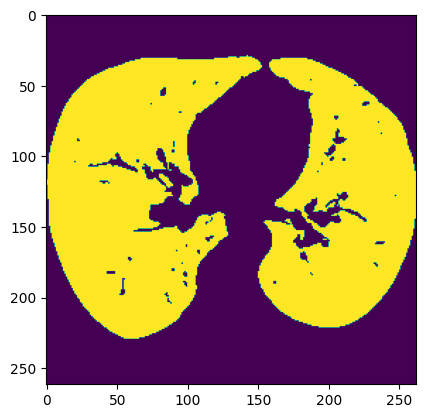

In [116]:
croppedImage = crop_image(mask_ot)
plt.imshow(croppedImage)

Quellen:
https://github.com/lukepolson/youtube_channel/blob/main/Python%20Tutorial%20Series/image_processing1.ipynb
https://www.kaggle.com/code/modoucair/medical-image-analysis
https://towardsdatascience.com/medical-image-pre-processing-with-python-d07694852606
https://dicom.innolitics.com/ciods/digital-x-ray-image/dx-image/00281052
https://flexikon.doccheck.com/de/Hounsfield-Skala
https://www.researchgate.net/figure/Abbildung-2513-Die-Hounsfield-Skala-HU-fuer-verschiedene-Gewebearten-74_fig1_286375965